In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
    """Generate class weights for imbalanced datasets.

      Args:
          class_series (list): List of class labels.
          multi_class (bool, optional): Defines if data is multiclass. Defaults to True.
          one_hot_encoded (bool, optional): Defines if data is one hot encoded. Defaults to False.

      Returns:
          dict: Dictionary of class weights and labels.
    """
    if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
        if one_hot_encoded:
            class_series = np.argmax(class_series, axis=1)

        # Compute class weights with sklearn method
        class_labels = np.unique(class_series)
        class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
        return dict(zip(class_labels, class_weights))
    else:
    # It is neccessary that the multi-label values are one-hot encoded
        mlb = None
        if not one_hot_encoded:
            mlb = MultiLabelBinarizer()
            class_series = mlb.fit_transform(class_series)

        n_samples = len(class_series)
        n_classes = len(class_series[0])

        # Count each class frequency
        class_count = [0] * n_classes
        for classes in class_series:
            for index in range(n_classes):
                if classes[index] != 0:
                    class_count[index] += 1

    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

      
#Define a function to plot the loss per epoch 
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.figure()
    plt.plot(history.history['accuracy'], label="acc")
    plt.plot(history.history['val_accuracy'], label="val.acc")
    plt.xlabel('Epoch')
    plt.ylabel('Acc.')
    
    #Define the model again with the optimal params.

In [3]:
def save_network_structure(net, version):
    """ Plot the loss per epoch.

    Args:
        history (list): List of history objects.
    """
    summary = net.summary()
    model_path = create_folder('../reports/'+version+"/train/")
    model_name = 'network_structure.png'
    plot_model(net, to_file=os.path.join(
        model_path, model_name), show_shapes=True)

    print(summary)


def create_folder(path):
    """ Create folder if it does not exist.

    Args:
        path (string): Path to create.

    Returns:
        string: Created path
    """

    new_path = os.path.join(path)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    return new_path

In [4]:
def load_data():
    """ Load training data and lables.

    Returns:
        list, list, list: Training data and class weights.
    """
    #Load colorplot datasets. 
    X = np.load('data.npz')['a'].reshape(5179, 200, 100, 1)

    #Creating the labels. 
    y = pd.read_excel('Labels_v1.xlsx', header = None).values

    #Shuffling the dataset.
    shuffler = np.random.permutation(len(y))
    X = X[shuffler]
    y = y[shuffler]
    class_weights = generate_class_weights(y[:,0])
    print(class_weights)
    print(np.unique(y[:,0]))
    
    return X, y, class_weights

In [5]:
def build_cnn(version, input_shape=(200, 100, 1), num_classes=2):
    """ Build the CNN model.

        Args:
                version (string): Version of the network.

        Returns:
                any: Model.
    """
    
    # Create input layer
    inputs = keras.Input(shape=input_shape)

    # Add convolutional layer, batch normalization, and relu activation on input layer
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Add convolutional layer, batch normalization, and relu activation on previous layer
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Add separable convolutional layer with different sizes, batch normalization, and relu activation on previous layer
    for size in [128, 256, 512, 728, 1024]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # if adding flatten layer reduce number of filters cause its going to be massive
    # x = layers.SeparableConv2D(128, 3, padding="same")(x)
    x = layers.SeparableConv2D(2048, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Flatten()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    model = keras.Model(inputs, outputs)
    model.summary()
    return model

In [6]:
def train(version):
    """ Train the model.

    Args:
        version (string): Version of the model.
    """
    
    # Define the K-fold Cross Validator
    X, y, class_weights = load_data()

    num_folds = 5
    kfold = KFold(n_splits=num_folds, shuffle=True)

    # Define optimiser with a changed learning rate
    opt = tf.keras.optimizers.Adam(
        learning_rate=1e-05,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam",
    )

    inputs = X
    targets = np.asarray(y).astype('float32').reshape((-1, 1))
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        # Train the model
        
        # Save best model after each epoch
        model_path = create_folder('../models/'+version+"/")
        file_name = "version_"+version + \
            "_best_model_fold-" + str(fold_no) + ".h5"

        file_path = os.path.join(
            model_path, file_name)

        # Define early stopping callback
        es = [EarlyStopping(monitor='val_loss', mode='min', patience=40, min_delta=0.01), tf.keras.callbacks.ModelCheckpoint(
            file_path,
            monitor="val_loss",
            verbose=1,
            save_best_only=True
        )]

        net = build_cnn(version)

        net.compile(loss='binary_crossentropy',
                    optimizer=opt, metrics="accuracy")

        history = net.fit(
            # changed expression for test features and labels
            inputs[train], targets[train],
            # I removed validation for k-fold cross validation
            validation_split=0.25,
            verbose=1, epochs=10000,
            class_weight=class_weights, callbacks=es)

        newfig = plt.figure()
        plot_loss(history)

        plt.show()
        # Prediction of the validation dataset
        test_predictions = net.predict(inputs[test]).flatten()
        fold_no = fold_no + 1

In [7]:
def test(filename):
    """ Test the model.

    Args:
        filename (string): Path to the model.
    """

    net = load_model(filename)
    labels_train = y

    outputs = net.predict(X)
    labels_predicted = np.argmax(outputs, axis=1)
    misclassified = sum(labels_predicted != labels_train)
    print('Percentage misclassified = ',
          100*misclassified/labels_train.size)
    print('Percentage misclassified = ',
          sum(100*misclassified/labels_train.size)/labels_train.size)

    plt.figure(figsize=(8, 2))
    for i in range(0, 8):
        ax = plt.subplot(2, 8, i+1)
        plt.imshow(X[i, :].reshape(200, 100), cmap=plt.get_cmap('gray_r'))
        plt.title(labels_train[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    for i in range(0, 8):
        output = net.predict(X[i, :].reshape(1, 200, 100, 1))
        output = output[0, 0:]
        plt.subplot(2, 8, 8+i+1)
        plt.bar(np.arange(10.), output)
        plt.title(np.argmax(output))

    net.summary()

    plot_model(net, to_file='network_structure.png', show_shapes=True)
    plt.show()


{0: 0.5977608494921515, 1: 3.0572609208972845}
[0 1]
Metal device set to: Apple M1 Max


2022-03-31 20:28:36.717924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-31 20:28:36.718028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 50, 32)  320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 50, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

2022-03-31 20:28:37.099581: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-31 20:28:37.640686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.5379 - accuracy: 0.6810

2022-03-31 20:28:48.741825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.69619, saving model to ../models/3.0/version_3.0_best_model_fold-1.h5


/Users/tomas/miniforge3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


98/98 [==============================] - 13s 121ms/step - loss: 0.5379 - accuracy: 0.6810 - val_loss: 0.6962 - val_accuracy: 0.1583
Epoch 2/10000
97/98 [============================>.] - ETA: 0s - loss: 0.3992 - accuracy: 0.7935
Epoch 00002: val_loss improved from 0.69619 to 0.67038, saving model to ../models/3.0/version_3.0_best_model_fold-1.h5
98/98 [==============================] - 11s 116ms/step - loss: 0.3992 - accuracy: 0.7937 - val_loss: 0.6704 - val_accuracy: 0.8417
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.3368 - accuracy: 0.8447
Epoch 00003: val_loss improved from 0.67038 to 0.60970, saving model to ../models/3.0/version_3.0_best_model_fold-1.h5
98/98 [==============================] - 11s 115ms/step - loss: 0.3369 - accuracy: 0.8445 - val_loss: 0.6097 - val_accuracy: 0.8417
Epoch 4/10000
97/98 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8718
Epoch 00004: val_loss improved from 0.60970 to 0.51279, saving model to ../

97/98 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9968
Epoch 00028: val_loss did not improve from 0.18323
98/98 [==============================] - 11s 113ms/step - loss: 0.0192 - accuracy: 0.9968 - val_loss: 0.2489 - val_accuracy: 0.9180
Epoch 29/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0224 - accuracy: 0.9961
Epoch 00029: val_loss did not improve from 0.18323
98/98 [==============================] - 11s 112ms/step - loss: 0.0224 - accuracy: 0.9961 - val_loss: 0.2325 - val_accuracy: 0.9295
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9965
Epoch 00030: val_loss did not improve from 0.18323
98/98 [==============================] - 11s 112ms/step - loss: 0.0182 - accuracy: 0.9965 - val_loss: 0.2297 - val_accuracy: 0.9353
Epoch 31/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9971
Epoch 00031: val_loss did not improve from 0.18323
98/98 [================

<Figure size 432x288 with 0 Axes>

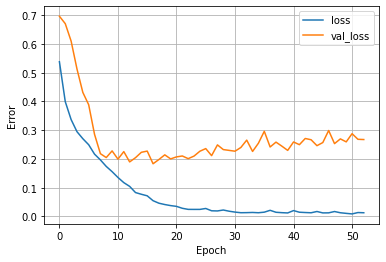

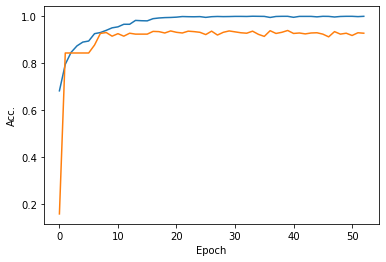

2022-03-31 20:38:26.412842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 100, 50, 32)  320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_13 (BatchN  (None, 100, 50, 32)  128        ['conv2d_7[0][0]']               
 ormalization)                                                                                    
                                                                                            

2022-03-31 20:38:28.175948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.3828 - accuracy: 0.8143

2022-03-31 20:38:39.609918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.65817, saving model to ../models/3.0/version_3.0_best_model_fold-2.h5
98/98 [==============================] - 13s 127ms/step - loss: 0.3828 - accuracy: 0.8143 - val_loss: 0.6582 - val_accuracy: 0.8369
Epoch 2/10000
97/98 [============================>.] - ETA: 0s - loss: 0.2629 - accuracy: 0.8885
Epoch 00002: val_loss improved from 0.65817 to 0.58370, saving model to ../models/3.0/version_3.0_best_model_fold-2.h5
98/98 [==============================] - 11s 116ms/step - loss: 0.2638 - accuracy: 0.8883 - val_loss: 0.5837 - val_accuracy: 0.8369
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.2131 - accuracy: 0.9137
Epoch 00003: val_loss improved from 0.58370 to 0.50823, saving model to ../models/3.0/version_3.0_best_model_fold-2.h5
98/98 [==============================] - 11s 115ms/step - loss: 0.2130 - accuracy: 0.9134 - val_loss: 0.5082 - val_accuracy: 0.8369
Epoch 4/10000
97/98 [============================>.] - E

Epoch 29/10000
98/98 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9977
Epoch 00029: val_loss did not improve from 0.17076
98/98 [==============================] - 11s 113ms/step - loss: 0.0115 - accuracy: 0.9977 - val_loss: 0.2112 - val_accuracy: 0.9353
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9981
Epoch 00030: val_loss did not improve from 0.17076
98/98 [==============================] - 11s 111ms/step - loss: 0.0118 - accuracy: 0.9977 - val_loss: 0.3504 - val_accuracy: 0.8851
Epoch 31/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0247 - accuracy: 0.9916
Epoch 00031: val_loss did not improve from 0.17076
98/98 [==============================] - 11s 112ms/step - loss: 0.0247 - accuracy: 0.9916 - val_loss: 0.2519 - val_accuracy: 0.9170
Epoch 32/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9971
Epoch 00032: val_loss did not improve from 0.17076
98/98 [=

<Figure size 432x288 with 0 Axes>

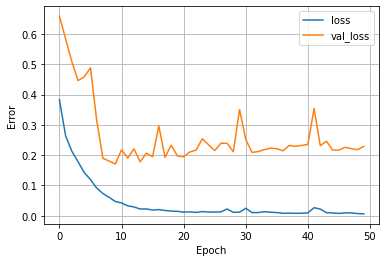

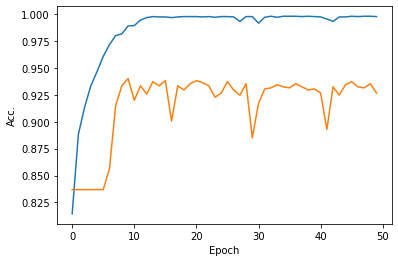

2022-03-31 20:47:43.842588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 100, 50, 32)  320         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_26 (BatchN  (None, 100, 50, 32)  128        ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                            

Epoch 1/10000


2022-03-31 20:47:45.698042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.8098

2022-03-31 20:47:57.625438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.65783, saving model to ../models/3.0/version_3.0_best_model_fold-3.h5
98/98 [==============================] - 14s 130ms/step - loss: 0.3924 - accuracy: 0.8098 - val_loss: 0.6578 - val_accuracy: 0.8369
Epoch 2/10000
98/98 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.8803
Epoch 00002: val_loss improved from 0.65783 to 0.58385, saving model to ../models/3.0/version_3.0_best_model_fold-3.h5
98/98 [==============================] - 12s 118ms/step - loss: 0.2841 - accuracy: 0.8803 - val_loss: 0.5839 - val_accuracy: 0.8369
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.2232 - accuracy: 0.9104
Epoch 00003: val_loss improved from 0.58385 to 0.50410, saving model to ../models/3.0/version_3.0_best_model_fold-3.h5
98/98 [==============================] - 11s 117ms/step - loss: 0.2235 - accuracy: 0.9105 - val_loss: 0.5041 - val_accuracy: 0.8369
Epoch 4/10000
97/98 [============================>.] - E

Epoch 29/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.9987
Epoch 00029: val_loss did not improve from 0.18329
98/98 [==============================] - 11s 117ms/step - loss: 0.0094 - accuracy: 0.9984 - val_loss: 0.2402 - val_accuracy: 0.9315
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9932
Epoch 00030: val_loss did not improve from 0.18329
98/98 [==============================] - 11s 117ms/step - loss: 0.0175 - accuracy: 0.9932 - val_loss: 0.2514 - val_accuracy: 0.9170
Epoch 31/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.9987
Epoch 00031: val_loss did not improve from 0.18329
98/98 [==============================] - 11s 117ms/step - loss: 0.0103 - accuracy: 0.9987 - val_loss: 0.2687 - val_accuracy: 0.9199
Epoch 32/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0063 - accuracy: 0.9987
Epoch 00032: val_loss did not improve from 0.18329
98/98 [=

<Figure size 432x288 with 0 Axes>

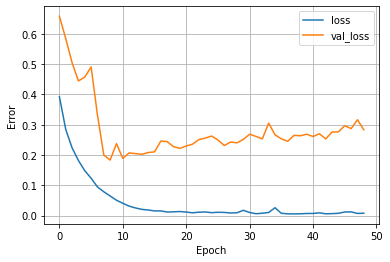

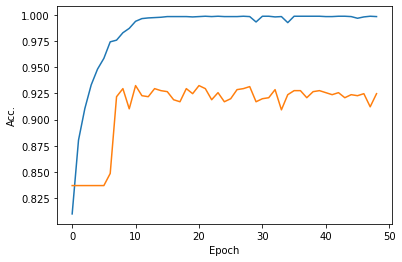

2022-03-31 20:57:14.093131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 100, 50, 32)  320         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_39 (BatchN  (None, 100, 50, 32)  128        ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                            

2022-03-31 20:57:16.795634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.8130

2022-03-31 20:57:28.952218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.66028, saving model to ../models/3.0/version_3.0_best_model_fold-4.h5
98/98 [==============================] - 15s 137ms/step - loss: 0.3888 - accuracy: 0.8130 - val_loss: 0.6603 - val_accuracy: 0.8378
Epoch 2/10000
98/98 [==============================] - ETA: 0s - loss: 0.2578 - accuracy: 0.8980
Epoch 00002: val_loss improved from 0.66028 to 0.58588, saving model to ../models/3.0/version_3.0_best_model_fold-4.h5
98/98 [==============================] - 13s 128ms/step - loss: 0.2578 - accuracy: 0.8980 - val_loss: 0.5859 - val_accuracy: 0.8378
Epoch 3/10000
98/98 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.9231
Epoch 00003: val_loss improved from 0.58588 to 0.50012, saving model to ../models/3.0/version_3.0_best_model_fold-4.h5
98/98 [==============================] - 13s 128ms/step - loss: 0.1986 - accuracy: 0.9231 - val_loss: 0.5001 - val_accuracy: 0.8378
Epoch 4/10000
98/98 [==============================] - E

Epoch 29/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0195 - accuracy: 0.9948
Epoch 00029: val_loss did not improve from 0.16332
98/98 [==============================] - 11s 111ms/step - loss: 0.0195 - accuracy: 0.9949 - val_loss: 0.2375 - val_accuracy: 0.9286
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9965
Epoch 00030: val_loss did not improve from 0.16332
98/98 [==============================] - 11s 112ms/step - loss: 0.0146 - accuracy: 0.9965 - val_loss: 0.1993 - val_accuracy: 0.9324
Epoch 31/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9961
Epoch 00031: val_loss did not improve from 0.16332
98/98 [==============================] - 11s 112ms/step - loss: 0.0154 - accuracy: 0.9961 - val_loss: 0.2198 - val_accuracy: 0.9266
Epoch 32/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.9961
Epoch 00032: val_loss did not improve from 0.16332
98/98 [=

<Figure size 432x288 with 0 Axes>

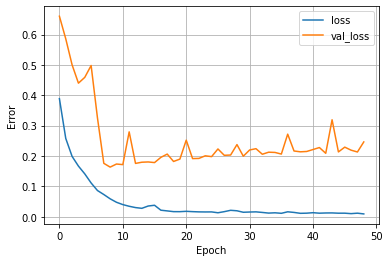

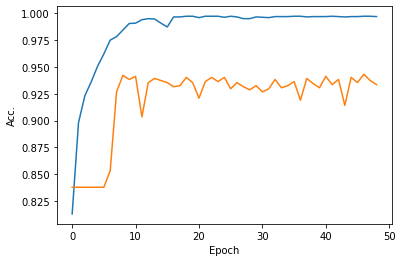

2022-03-31 21:06:27.584285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 100, 50, 32)  320         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_52 (BatchN  (None, 100, 50, 32)  128        ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                                            

2022-03-31 21:06:29.345408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.3926 - accuracy: 0.8053

2022-03-31 21:06:43.088479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.66123, saving model to ../models/3.0/version_3.0_best_model_fold-5.h5
98/98 [==============================] - 16s 152ms/step - loss: 0.3926 - accuracy: 0.8053 - val_loss: 0.6612 - val_accuracy: 0.8436
Epoch 2/10000
98/98 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.8761
Epoch 00002: val_loss improved from 0.66123 to 0.59536, saving model to ../models/3.0/version_3.0_best_model_fold-5.h5
98/98 [==============================] - 12s 123ms/step - loss: 0.2742 - accuracy: 0.8761 - val_loss: 0.5954 - val_accuracy: 0.8436
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.2293 - accuracy: 0.9046
Epoch 00003: val_loss improved from 0.59536 to 0.51019, saving model to ../models/3.0/version_3.0_best_model_fold-5.h5
98/98 [==============================] - 12s 120ms/step - loss: 0.2298 - accuracy: 0.9048 - val_loss: 0.5102 - val_accuracy: 0.8436
Epoch 4/10000
97/98 [============================>.] - E

Epoch 29/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9984
Epoch 00029: val_loss did not improve from 0.17232
98/98 [==============================] - 11s 113ms/step - loss: 0.0085 - accuracy: 0.9984 - val_loss: 0.2097 - val_accuracy: 0.9334
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9981
Epoch 00030: val_loss did not improve from 0.17232
98/98 [==============================] - 11s 110ms/step - loss: 0.0106 - accuracy: 0.9981 - val_loss: 0.2156 - val_accuracy: 0.9324
Epoch 31/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9974
Epoch 00031: val_loss did not improve from 0.17232
98/98 [==============================] - 11s 112ms/step - loss: 0.0129 - accuracy: 0.9974 - val_loss: 0.2228 - val_accuracy: 0.9266
Epoch 32/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9981
Epoch 00032: val_loss did not improve from 0.17232
98/98 [=

<Figure size 432x288 with 0 Axes>

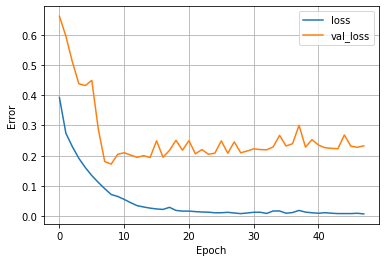

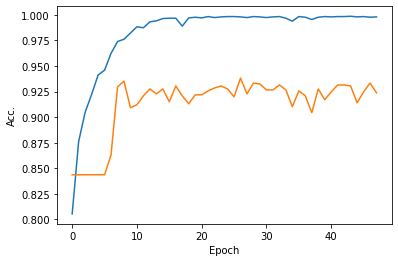

2022-03-31 21:15:31.809638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [8]:
train("3.0")

In [ ]:
test('cnn_for_5H_trial1.h5')